In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [3]:
# Connect to Database
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

In [4]:
# Load Tasks
query = "SELECT * FROM Tasks"
df_tasks = pd.read_sql(query, cnx)
# display(df_tasks.head(1))

# Load types of tasks
query = "SELECT * FROM TaskTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)
# display(df_types.head(1))

# Assign types to tasks
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')
# display(df_tasks.head(1))

# Select tasks of type "OPEN"
df_open_tasks = df_tasks[df_tasks["type"] == "OPEN"]

# Load Last versions of tasks
query = "SELECT * FROM LatestTaskVersions"
df_latest = pd.read_sql(query, cnx)
# display(df_latest.head(1))

# Select last versions of Open tasks
df_latest_open_versions = pd.merge(df_open_tasks, df_latest, how="inner", on=["version", "taskId"])
# display(df_latest_open_versions.head(1))
print(f"Number of OPEN tasks, playground included: {len(df_latest_open_versions)}")

Number of OPEN tasks, playground included: 3829


In [5]:
# Remove playground tasks, and those with Nan tenant
df_content = df_latest_open_versions["content"].apply(json.loads).apply(pd.Series)
df_content.rename(columns={"id":"taskId"}, inplace=True)
# display(df_content.head(1))

df_tenants = df_content["tenant"].apply(pd.Series)
df_tenants.rename(columns={"name":"tenant_name"}, inplace=True)
# display(df_tenants.head(1))

df_content = pd.concat([df_content, df_tenants], axis=1)
print("Percentage of tasks with unspecified tenant: {:.2f}%".format(len(df_content[df_content["tenant_name"].isna()]) / len(df_content) * 100))
df_content.dropna(subset=["tenant_name"], inplace=True)
df_playground = df_content[df_content["tenant_name"].str.contains('playground', case=False)]
print("Percentage of playground tasks (after removing Nan tenants): {:.2f}%".format(len(df_playground) / len(df_content) * 100))
df_content = df_content.drop(df_playground.index)
df_open_tasks = df_content.copy()
print(f"Number of OPEN tasks after removing Playground and Nan tenants: {len(df_open_tasks)}")
# display(df_open_tasks.head(1))

# Cleaning DataFrame
columns_to_keep = ["taskId", "language", "description", "context", "topic"]
df_open_tasks = df_open_tasks[columns_to_keep]
df_open_tasks.dropna(axis=1, how="all")

# Extract topic ID, potentially useful later
df_topics = df_open_tasks["topic"].apply(pd.Series)
df_topics.rename(columns={"id":"topic_id"}, inplace=True)
# display(df_topics.head(1))

df_open_tasks = pd.concat([df_open_tasks.drop("topic", axis=1), df_topics[["topic_id"]]], axis=1)
# display(df_open_tasks.head(1))

print(f"\nFinal number of tasks after cleaning: {len(df_open_tasks)}")

Percentage of tasks with unspecified tenant: 3.94%
Percentage of playground tasks (after removing Nan tenants): 10.03%
Number of OPEN tasks after removing Playground and Nan tenants: 3309

Final number of tasks after cleaning: 3309


<hr>

**Augment description with context**

In [6]:
df_open_tasks["description"] = df_open_tasks.apply(
    lambda row: row["description"]+" "+row["context"] 
    if isinstance(row["context"], str) 
    else row["description"], 
    axis=1)
df_open_tasks.drop(columns=["context"], inplace=True)
# df_open_tasks.head(1)

<hr>

**Cleaning description**

In [7]:
df_open_tasks["description"] = df_open_tasks["description"].apply(
    lambda text: BeautifulSoup(str(text), 'html.parser').get_text(separator=" ", strip=True).strip())

print("Number of tasks with Nan description: {}".format(len(df_open_tasks) - len(df_open_tasks.dropna(subset=["description"]))))
print("Number of tasks with Empty description: {}".format(len(df_open_tasks[df_open_tasks["description"] == ""])))

#Remove empty descriptions 
df_open_tasks = df_open_tasks[df_open_tasks["description"] != ""] 
print(f"\nFinal number of tasks with non empty descriptions: {len(df_open_tasks)}")

Number of tasks with Nan description: 0
Number of tasks with Empty description: 114

Final number of tasks with non empty descriptions: 3195


<hr>

**Visualization**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

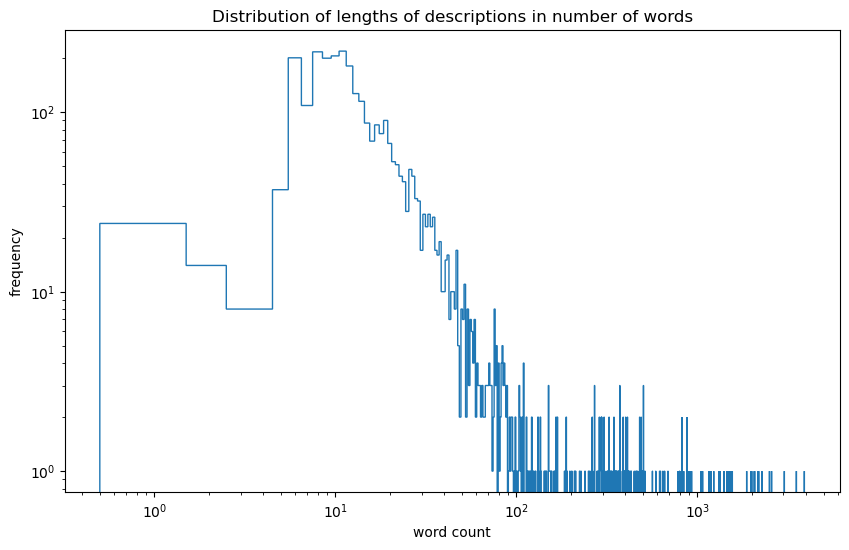

In [9]:
# Word count
df_open_tasks["word_count"] = df_open_tasks["description"].apply(lambda s: len(s.split())) 

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
word_count = df_open_tasks["word_count"].to_list()
plt.hist(word_count, bins=np.arange(max(word_count)+2)-0.5, histtype='step')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of lengths of descriptions in number of words")
ax.set_xlabel("word count")
ax.set_ylabel("frequency")
plt.show()

In [10]:
print("Percentage of descriptions with less than 5 words: {:.2f}%".format(len(df_open_tasks[df_open_tasks["word_count"] < 5]) / len(df_open_tasks) * 100))
print("Percentage of descriptions with less than 10 words: {:.2f}%".format(len(df_open_tasks[df_open_tasks["word_count"] < 10]) / len(df_open_tasks) * 100))

Percentage of descriptions with less than 5 words: 1.69%
Percentage of descriptions with less than 10 words: 25.60%


In [11]:
def get_bow(text_data):
    # create the vocabulary
    vectorizer = CountVectorizer(input='content', stop_words=None, ngram_range=(1,1))
    
    # fit the vocabulary to the text data
    vectorizer.fit(text_data)
    
    # create the bag-of-words model
    bow_model = vectorizer.transform(text_data)

    return vectorizer, bow_model

In [12]:
text_data = df_open_tasks["description"].tolist() 
vectorizer, bow_model = get_bow(text_data)
words = vectorizer.vocabulary_.keys()
word_lengths = [len(word) for word in words] 

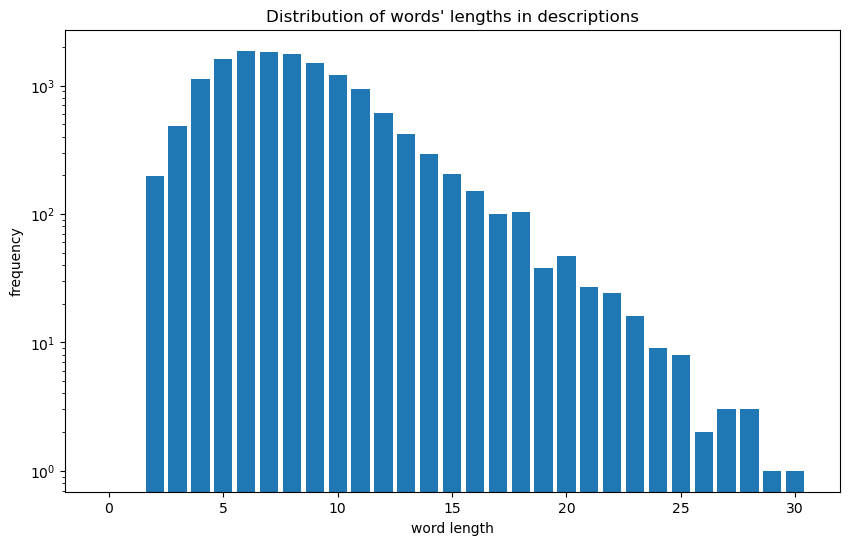

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(word_lengths, bins=np.arange(max(word_lengths)+2)-0.5, histtype='bar', rwidth=0.8)
ax.set_yscale("log")
ax.set_title("Distribution of words' lengths in descriptions")
ax.set_xlabel("word length")
ax.set_ylabel("frequency")
plt.show()

<hr>

**Fixing language field**

In [14]:
import nltk
from nltk import classify
from nltk import textcat
# nltk.download('crubadan')
# nltk.download('punkt')

def detect_lang(detector, text):
    try:
        return detector.guess_language(text)
    except:
        return ""

detector = textcat.TextCat()
df_open_tasks["language"] = df_open_tasks["description"].apply(lambda text: detect_lang(detector, text))
df_open_tasks.to_csv("language_detected.csv", index_label=False)

In [91]:
df_open_tasks = pd.read_csv("language_detected.csv")
df_open_tasks["language"] = df_open_tasks["language"].str.strip()
df_open_tasks.language.unique()

array(['deu', 'fra', 'pdc', 'eng', 'ita', 'fur', 'nds', 'vec', 'lat',
       'pam', 'ksh', 'lnc', 'por', 'swe', 'ukr', 'lmo', 'nob', 'gsw',
       'sot', 'est', 'cat', 'glg', 'ssw', 'dan', 'miq', 'epo', 'mlt',
       'ltz'], dtype=object)

In [93]:
# df_open_tasks = pd.merge(df_open_tasks, df_content[["taskId", "tenant_name"]], how="inner", on=["taskId"])
df_open_tasks = pd.merge(df_open_tasks.drop("tenant_name", axis=1), df_content[["taskId", "tenant_name"]], how="inner", on=["taskId"])
len(df_open_tasks)

3195

In [94]:
pd.set_option("display.max_rows", None)
df_translator = df_open_tasks[df_open_tasks["tenant_name"] == "DataEnricher"]
df_open_tasks = df_open_tasks[df_open_tasks["tenant_name"] != "DataEnricher"]

idx = df_open_tasks[df_open_tasks["tenant_name"].isin(["connectsolutions_fr", "connectsolutions_it"])].index
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('translate', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('übersetzen', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('übersetze', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

df_eng = df_open_tasks[df_open_tasks["language"] == "eng"]
df_deu = df_open_tasks[df_open_tasks["language"] == "deu"]

idx = df_eng[df_eng["tenant_name"].isin(["connectsolutions_de", "Marketing Grundlagen"])].index
df_eng = df_eng.drop(idx)
df_deu = pd.concat([df_deu, df_open_tasks.loc[idx]])

In [95]:
df_open_tasks.language.unique()

array(['deu', 'pdc', 'eng', 'fra', 'ita', 'nds', 'lat', 'pam', 'ksh',
       'swe', 'ukr', 'sot', 'est', 'por', 'cat', 'glg', 'nob', 'miq',
       'epo', 'gsw', 'mlt', 'ltz'], dtype=object)

In [96]:
# display(df_open_tasks[df_open_tasks["language"].isin(["nds", "gsw", "ltz", "ksh"])].sort_values(by="language")) 
idx = df_open_tasks[df_open_tasks["language"].isin(["nds", "gsw", "ltz", "ksh"])].index
df_deu = pd.concat([df_deu, df_open_tasks.loc[idx]])

In [87]:
# display(df_open_tasks[~ df_open_tasks["language"].isin(["nds", "gsw", "ltz", "ksh", "deu", "eng"])].sort_values(by="language"))

In [89]:
df_eng["language"] = "eng" 
df_deu["language"] = "deu" 

In [102]:
df_eng.drop("tenant_name", axis=1).to_csv("data/open_tasks_EN.csv", index_label=False)

In [103]:
df_deu.drop("tenant_name", axis=1).to_csv("data/open_tasks_DE.csv", index_label=False)

In [105]:
df_translator.drop("tenant_name", axis=1).to_csv("data/translate_tasks.csv", index_label=False)

In [106]:
len(df_eng), len(df_deu), len(df_translator)

(299, 1556, 647)